In [18]:
import sys
sys.path.insert(0, '/users/ankushroy/iris/src')
print(sys.path)

['/users/ankushroy/iris/src', '/users/ankushroy/iris/src', '/users/ankushroy/iris/src', '/users/ankushroy/iris/src/models/tokenizer', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python38.zip', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8/lib-dynload', '', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8/site-packages']


In [9]:
from dataclasses import dataclass
from typing import Any, Tuple

from einops import rearrange
import torch
import torch.nn as nn

#from dataset import Batch
from lpips import LPIPS
from nets import Encoder, Decoder
from utils import LossWithIntermediateLosses

batch=1
@dataclass
class TokenizerEncoderOutput:
    z: torch.FloatTensor
    z_quantized: torch.FloatTensor
    tokens: torch.LongTensor


class Tokenizer(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, encoder: Encoder, decoder: Decoder, with_lpips: bool) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.encoder = encoder
        self.pre_quant_conv = torch.nn.Conv2d(encoder.config.z_channels, embed_dim, 1)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, decoder.config.z_channels, 1)
        self.decoder = decoder
        self.embedding.weight.data.uniform_(-1.0 / vocab_size, 1.0 / vocab_size)
        self.lpips = LPIPS().eval() if with_lpips else None

    def __repr__(self) -> str:
        return "tokenizer"

    def forward(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> Tuple[torch.Tensor]:
        outputs = self.encode(x, should_preprocess)
        decoder_input = outputs.z + (outputs.z_quantized - outputs.z).detach()
        reconstructions = self.decode(decoder_input, should_postprocess)
        return outputs.z, outputs.z_quantized, reconstructions

    def compute_loss(self, x, **kwargs: Any) -> LossWithIntermediateLosses:
        assert self.lpips is not None
        observations = x
        z, z_quantized, reconstructions = self(observations, should_preprocess=False, should_postprocess=False)

        # Codebook loss. Notes:
        # - beta position is different from taming and identical to original VQVAE paper
        # - VQVAE uses 0.25 by default
        beta = 1.0
        commitment_loss = (z.detach() - z_quantized).pow(2).mean() + beta * (z - z_quantized.detach()).pow(2).mean()

        reconstruction_loss = torch.abs(observations - reconstructions).mean()
        perceptual_loss = torch.mean(self.lpips(observations, reconstructions))

        return LossWithIntermediateLosses(commitment_loss=commitment_loss, reconstruction_loss=reconstruction_loss,perceptual_loss=perceptual_loss)

    def encode(self, x: torch.Tensor, should_preprocess: bool = False) -> TokenizerEncoderOutput:
        if should_preprocess:
            x = self.preprocess_input(x)
        #print("Shape of x:", x.shape)
        shape = x.shape  # (..., C, H, W)
        x = x.view(-1, *shape[-3:])
        #print("Shape of x as (x_view):", x.shape)
        z = self.encoder(x)
        #print("Shape of z:",z.shape)
        z = self.pre_quant_conv(z)
        b, e, h, w = z.shape
        z_flattened = rearrange(z, 'b e h w -> (b h w) e')
        #print("Shape of z_flattend:",z_flattened.shape)
        dist_to_embeddings = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.matmul(z_flattened, self.embedding.weight.t())

        tokens = dist_to_embeddings.argmin(dim=-1)
        #print("Shape of tokens:",tokens.shape)
        z_q = rearrange(self.embedding(tokens), '(b h w) e -> b e h w', b=b, e=e, h=h, w=w).contiguous()
        #print("Shape of z_q:",z_q.shape)
        # Reshape to original
        z = z.reshape(*shape[:-3], *z.shape[1:])
        #print("Shape of reshaped z:", z.shape)
        z_q = z_q.reshape(*shape[:-3], *z_q.shape[1:])
        #print("Shape of reshaped z_q:", z_q.shape)
        tokens = tokens.reshape(*shape[:-3], -1)
        #print("Shape of tokens:", tokens.shape)

        return TokenizerEncoderOutput(z, z_q, tokens)

    def decode(self, z_q: torch.Tensor, should_postprocess: bool = False) -> torch.Tensor:
        shape = z_q.shape  # (..., E, h, w)
        z_q = z_q.view(-1, *shape[-3:])
        z_q = self.post_quant_conv(z_q)
        rec = self.decoder(z_q)
        rec = rec.reshape(*shape[:-3], *rec.shape[1:])
        if should_postprocess:
            rec = self.postprocess_output(rec)
        return rec

    @torch.no_grad()
    def encode_decode(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> torch.Tensor:
        z_q = self.encode(x, should_preprocess).z_quantized
        return self.decode(z_q, should_postprocess)

    def preprocess_input(self, x: torch.Tensor) -> torch.Tensor:
        """x is supposed to be channels first and in [0, 1]"""
        return x.mul(2).sub(1)

    def postprocess_output(self, y: torch.Tensor) -> torch.Tensor:
        """y is supposed to be channels first and in [-1, 1]"""
        return y.add(1).div(2)


In [10]:
from typing import List

import torch
import torch.nn as nn
## Configuration file for the Endocer and Decoder
@dataclass
class EncoderDecoderConfig:
    resolution: int
    in_channels: int
    z_channels: int
    ch: int
    ch_mult: List[int]
    num_res_blocks: int
    attn_resolutions: List[int]
    out_ch: int
    dropout: float

Latent Space 16x16


In [20]:
encoder = Encoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=256,
                                        ch=128,
                                        ch_mult= [1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [16],
                                        out_ch= 1,
                                        dropout= 0.0))
decoder=Decoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=256,
                                        ch=128,
                                        ch_mult= [1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [16],
                                        out_ch= 1,
                                        dropout= 0.0))
vocab_size = 1024 # actual vocabulary size 
embed_dim = 256  # the desired embedding dimension of the codebook (coebook dim)
tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
#print(encoder)
#print(decoder)

Tokenizer : shape of latent is (256, 16, 16).


Latent Space 8x8

In [11]:
encoder = Encoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=1024,
                                        ch=128,
                                        ch_mult= [1, 1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [8],
                                        out_ch= 1,
                                        dropout= 0.0))
decoder=Decoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=1024,
                                        ch=128,
                                        ch_mult= [1, 1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [8],  
                                        out_ch= 1,
                                        dropout= 0.0))
vocab_size = 1024 # actual vocabulary size 
embed_dim = 1024  # the desired embedding dimension of the codebook (coebook dim)
tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
#print(encoder)
#print(decoder)

Tokenizer : shape of latent is (1024, 8, 8).


In [4]:
encoder = Encoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=256,
                                        ch=128,
                                        ch_mult= [1, 1, 2, 2, 4, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [8],
                                        out_ch= 1,
                                        dropout= 0.0))
decoder=Decoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=256,
                                        ch=128,
                                        ch_mult= [1, 1, 2, 2, 4, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [8],  
                                        out_ch= 1,
                                        dropout= 0.0))
vocab_size = 1024 # actual vocabulary size 
embed_dim = 256  # the desired embedding dimension of the codebook (coebook dim)
tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
#print(encoder)
#print(decoder)

Tokenizer : shape of latent is (256, 8, 8).


In [12]:
learning_rate=0.0001 # cfg training file 
optimizer_tokenizer = torch.optim.Adam(tokenizer.parameters(), lr=learning_rate)

In [13]:
# Define dataset
import torch
import sys
from nuwa_pytorch import VQGanVAE
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
#from scipy.ndimage import zoom
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print(datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes=time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes=time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs

from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from torchvision.transforms import ToTensor, Compose, CenterCrop
class radarDataset(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 3, pred_number = 6, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = []
        time_list = time_list_obs + time_list_pre
        #print(time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            #image = np.ma.masked_where(image == 65535, image)
            image = image[264:520,242:498]
            #image = zoom(image, (128 / image.shape[0], 128 / image.shape[1]))
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            #image = 2*image-1 #normalize to [-1,1]
            output.append(image)
            #print(image)
        output = torch.permute(torch.tensor(np.array(output)), (1, 2, 0))
        output = self.transform(np.array(output))
        return output
#root_dir = '/users/hbi/data/RAD_NL25_RAC_MFBS_EM_5min/'
#dataset = radarDataset(root_dir, ["200808031600"], transform = Compose([ToTensor(),CenterCrop(256)]))
#print(image.shape)

In [15]:
# develop dataset
#from torch.cuda.amp import autocast
#from torch.autograd import Variable
import pandas as pd

root_dir = '/home/hbi/RAD_NL25_RAP_5min/' 
batch_size=64

df_train = pd.read_csv('/users/ankushroy/taming-transformers/training_Delfland08-14_20.csv', header = None)
event_times = df_train[0].to_list()
dataset_train = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_s = pd.read_csv('/users/ankushroy/taming-transformers/training_Delfland08-14.csv', header = None)
event_times = df_train_s[0].to_list()
dataset_train_del = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_test = pd.read_csv('/users/ankushroy/taming-transformers/testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
dataset_test = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali = pd.read_csv('/users/ankushroy/taming-transformers/validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
dataset_vali = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_train_aa = pd.read_csv('/users/ankushroy/taming-transformers/training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
dataset_train_aa = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_dw = pd.read_csv('/users/ankushroy/taming-transformers/training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
dataset_train_dw = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

df_train_re = pd.read_csv('/users/ankushroy/taming-transformers/training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
dataset_train_re = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))   

data_list = [dataset_train_aa, dataset_train_dw, dataset_train_del, dataset_train_re]
train_aadedwre = torch.utils.data.ConcatDataset(data_list)
print(len(train_aadedwre), len(dataset_test), len(dataset_vali))
loaders = { 'train' :DataLoader(train_aadedwre, batch_size, shuffle=True, num_workers=8),
            'test' :DataLoader(dataset_test, batch_size, shuffle=False, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size, shuffle=False, num_workers=8),
          
          'train_aa5' :DataLoader(dataset_train_aa, batch_size, shuffle=False, num_workers=8),
          'train_dw5' :DataLoader(dataset_train_dw, batch_size, shuffle=False, num_workers=8),
          'train_del5' :DataLoader(dataset_train_del, batch_size, shuffle=True, num_workers=8),
          'train_re5' :DataLoader(dataset_train_re, batch_size, shuffle=False, num_workers=8),
          }

30632 3493 3560


Displaying images from train DataLoader


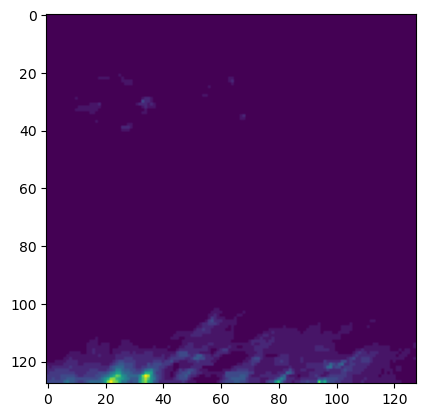

Displaying images from test DataLoader


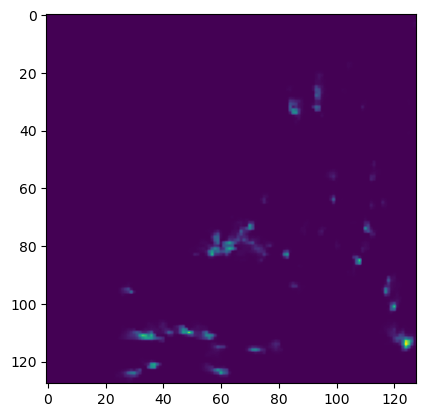

Displaying images from valid DataLoader


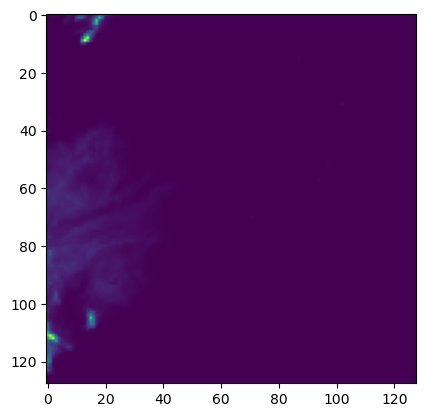

Displaying images from train_aa5 DataLoader


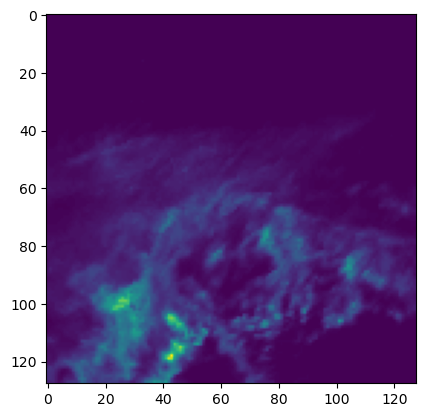

Displaying images from train_dw5 DataLoader


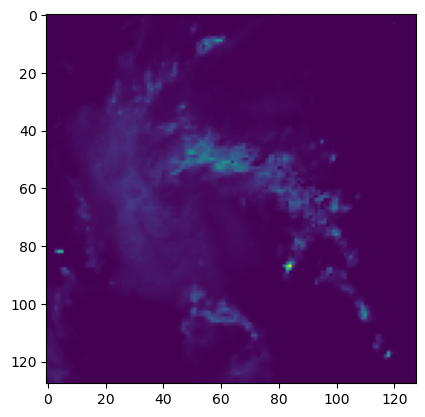

Displaying images from train_del5 DataLoader


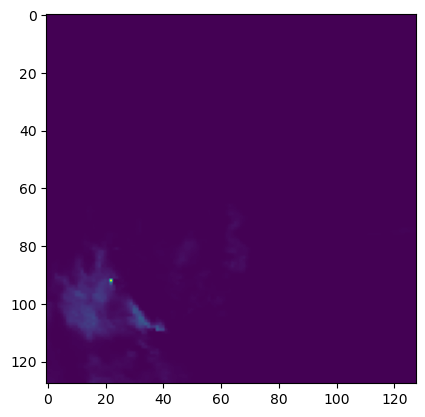

Displaying images from train_re5 DataLoader


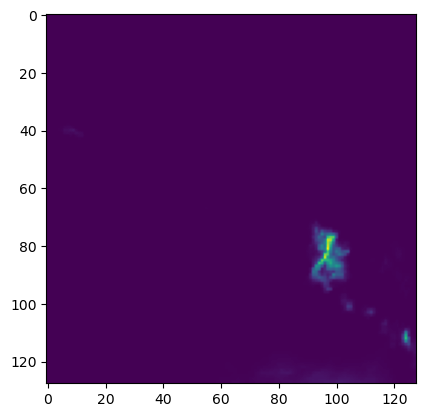

In [16]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img.numpy().squeeze()
    plt.imshow(img)
    plt.show()

# Display one image from each DataLoader
for name, loader in loaders.items():
    dataiter = iter(loader)
    images = dataiter.next()
    print(f"Displaying images from {name} DataLoader")
    print(images.shape)
    imshow(images[0][0])  # Display the first channel of the first image in the batch

Preprocessing of the Input Images to reduce resolution

In [16]:
# Initializing Device as cuda:0
cuda_version = torch.version.cuda
print("CUDA version:", cuda_version)
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("PyTorch version:", torch.__version__)

CUDA version: 11.3
True
cuda:0
PyTorch version: 1.11.0


In [17]:
##Training loop VQVAE 
import numpy as np
from collections import defaultdict
loss_total_step=0.0
intermediate_losses = defaultdict(float)
num_epochs=120
device = torch.device("cuda:0")  # Specify the GPU device
epoch_start=0
tokenizer.to(device)
all_metrics = []  # List to store metrics for all epochs

for epoch in range(epoch_start,num_epochs):
    save_epoch = epoch in [0,9,19,29,39,49,59,69,79,89,99,109,119]
    #save_epoch = epoch in [2]
    loss_total_epoch=0.0
    optimizer_tokenizer.zero_grad()
    intermediate_losses = {}
    print("epoch {}".format(epoch))
    for i, images in enumerate(loaders['train']):
        loss_total_step=0.0
        image = images[0]
        image = image.unsqueeze(1)
        image = image[3:4, :, :, :]
        input_image= image.to(device)  # batch x
        #print(input_image.size())
        encoder_output = tokenizer.encode(input_image)
        losses=tokenizer.compute_loss(input_image)
        
        loss_total_step += losses.loss_total 
        loss_total_epoch += loss_total_step.item()/64
        if (i+1) % 64 == 0:
            (loss_total_step/64).backward()
            optimizer_tokenizer.step()
            optimizer_tokenizer.zero_grad()
            
            print("Losses: Total = {:.4f}".format(loss_total_step.item()))
            #loss_total_step=0.0
        

        for loss_name, loss_value in losses.intermediate_losses.items():
                intermediate_losses[f"{str(tokenizer)}/train/{loss_name}"] = loss_value/64
    
        
    metrics = {f'{str(Tokenizer)}/train/total_loss': loss_total_epoch, **intermediate_losses}
    print("Epoch {}: Total Loss = {:.4f}".format(epoch, metrics[f'{str(Tokenizer)}/train/total_loss']))

    if save_epoch:
        torch.save({
        'model_state_dict': tokenizer.state_dict(),
        'optimizer_state_dict': optimizer_tokenizer.state_dict(),
        }, '/space/ankushroy/Tokeniser_exp2_1024_embdim_14/vqvae_checkpoint_epoch{}'.format(epoch+1))

    all_metrics.append(metrics)  # Save metrics for the current epoch to the list


# Convert the metrics list to a NumPy array
metrics_array = np.array(all_metrics)

# Save the metrics array as a NumPy file
np.save('/space/ankushroy/Tokeniser_exp2_1024_embdim_14/metrices.npy', metrics_array)
# Print all errors from each epoch's metrics dictionary
# print(all_metrics)

epoch 0
Losses: Total = 1.0392
Losses: Total = 1.4063
Losses: Total = 0.8304
Losses: Total = 0.7961
Losses: Total = 0.7008
Losses: Total = 0.5400
Losses: Total = 0.5392
Epoch 0: Total Loss = 6.1115
epoch 1
Losses: Total = 0.6157
Losses: Total = 0.5491
Losses: Total = 0.4301
Losses: Total = 0.5200
Losses: Total = 0.6710
Losses: Total = 0.6259
Losses: Total = 0.6049
Epoch 1: Total Loss = 4.3305
epoch 2
Losses: Total = 0.6486
Losses: Total = 0.7436
Losses: Total = 0.6336
Losses: Total = 0.6063
Losses: Total = 0.7932
Losses: Total = 0.5711
Losses: Total = 0.6698
Epoch 2: Total Loss = 5.0926
epoch 3
Losses: Total = 0.6200
Losses: Total = 0.7229
Losses: Total = 0.5852
Losses: Total = 0.5593
Losses: Total = 0.4555
Losses: Total = 0.6257
Losses: Total = 0.5793
Epoch 3: Total Loss = 4.2620
epoch 4
Losses: Total = 0.3777
Losses: Total = 0.4503
Losses: Total = 0.3202
Losses: Total = 0.2587
Losses: Total = 0.2845
Losses: Total = 0.2840
Losses: Total = 0.2933
Epoch 4: Total Loss = 2.6891
epoch 5
Lo

Losses: Total = 0.2725
Losses: Total = 0.2048
Losses: Total = 0.1043
Losses: Total = 0.2527
Losses: Total = 0.0626
Losses: Total = 0.1262
Epoch 41: Total Loss = 1.5003
epoch 42
Losses: Total = 0.2333
Losses: Total = 0.2948
Losses: Total = 0.1904
Losses: Total = 0.1844
Losses: Total = 0.0549
Losses: Total = 0.0634
Losses: Total = 0.2647
Epoch 42: Total Loss = 1.4940
epoch 43
Losses: Total = 0.1538
Losses: Total = 0.1738
Losses: Total = 0.2572
Losses: Total = 0.2600
Losses: Total = 0.1011
Losses: Total = 0.1039
Losses: Total = 0.2226
Epoch 43: Total Loss = 1.5258
epoch 44
Losses: Total = 0.1158
Losses: Total = 0.0557
Losses: Total = 0.0295
Losses: Total = 0.1539
Losses: Total = 0.1145
Losses: Total = 0.2837
Losses: Total = 0.3608
Epoch 44: Total Loss = 1.6447
epoch 45
Losses: Total = 0.2724
Losses: Total = 0.3079
Losses: Total = 0.3249
Losses: Total = 0.2527
Losses: Total = 0.4980
Losses: Total = 0.2580
Losses: Total = 0.2492
Epoch 45: Total Loss = 2.4311
epoch 46
Losses: Total = 0.3980


Losses: Total = 0.2086
Losses: Total = 0.1420
Losses: Total = 0.1913
Losses: Total = 0.2438
Losses: Total = 0.3289
Losses: Total = 0.3309
Epoch 82: Total Loss = 1.4706
epoch 83
Losses: Total = 0.1805
Losses: Total = 0.1451
Losses: Total = 0.1896
Losses: Total = 0.0548
Losses: Total = 0.3165
Losses: Total = 0.0563
Losses: Total = 0.1515
Epoch 83: Total Loss = 1.4855
epoch 84
Losses: Total = 0.1295
Losses: Total = 0.1308
Losses: Total = 0.1133
Losses: Total = 0.0530
Losses: Total = 0.2048
Losses: Total = 0.0531
Losses: Total = 0.1949
Epoch 84: Total Loss = 1.4114
epoch 85
Losses: Total = 0.2080
Losses: Total = 0.1556
Losses: Total = 0.2710
Losses: Total = 0.1608
Losses: Total = 0.2368
Losses: Total = 0.2205
Losses: Total = 0.1742
Epoch 85: Total Loss = 1.4460
epoch 86
Losses: Total = 0.2835
Losses: Total = 0.0412
Losses: Total = 0.1885
Losses: Total = 0.2830
Losses: Total = 0.1339
Losses: Total = 0.2920
Losses: Total = 0.2760
Epoch 86: Total Loss = 1.4647
epoch 87
Losses: Total = 0.0941


Losses: Total = 0.2180
Losses: Total = 0.3831
Losses: Total = 0.1770
Losses: Total = 0.0399
Losses: Total = 0.1620
Losses: Total = 0.1342
Losses: Total = 0.2074
Epoch 123: Total Loss = 1.4707
epoch 124
Losses: Total = 0.1350
Losses: Total = 0.3233
Losses: Total = 0.2270
Losses: Total = 0.0632
Losses: Total = 0.2015
Losses: Total = 0.2179
Losses: Total = 0.2209
Epoch 124: Total Loss = 1.4873
epoch 125
Losses: Total = 0.2191
Losses: Total = 0.2447
Losses: Total = 0.3024
Losses: Total = 0.0965
Losses: Total = 0.2933
Losses: Total = 0.2311
Losses: Total = 0.2679
Epoch 125: Total Loss = 1.4654
epoch 126
Losses: Total = 0.1278
Losses: Total = 0.1912
Losses: Total = 0.2998
Losses: Total = 0.2186
Losses: Total = 0.1083
Losses: Total = 0.1516
Losses: Total = 0.2332
Epoch 126: Total Loss = 1.4968
epoch 127
Losses: Total = 0.2953
Losses: Total = 0.2237
Losses: Total = 0.0741
Losses: Total = 0.2601
Losses: Total = 0.1069
Losses: Total = 0.0562
Losses: Total = 0.1601
Epoch 127: Total Loss = 1.4897


Reconstruction for 8x8 with 1024 as the codebook vector dimension

MSE: 14.68 MAE: 0.813 PCC: 0.444 
 CSI(1mm): 0.365 CSI(2mm): 0.297 CSI(8mm): 0.188 
 ACC(1mm): 0.915 ACC(2mm): 0.934 ACC(8mm): 0.972 
 FSS(1km): 0.935 FSS(10km): 0.904 FSS(20km): 0.833 FSS(30km): 0.647


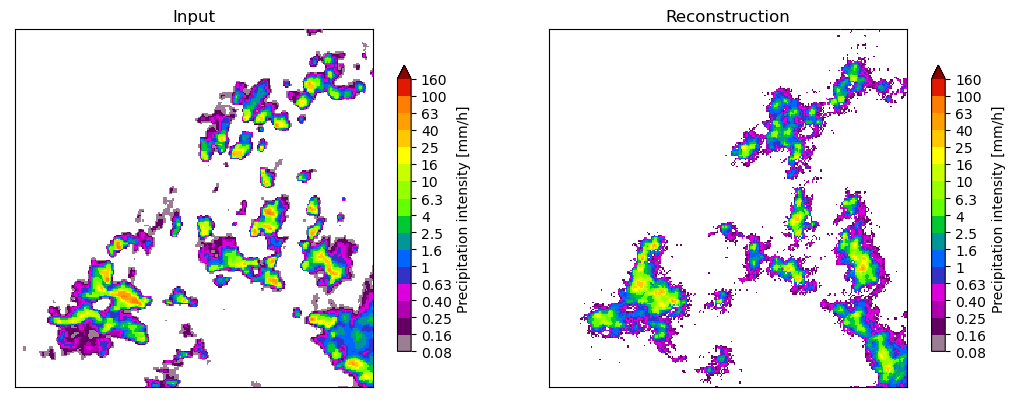

MSE: 14.196 MAE: 0.822 PCC: 0.441 
 CSI(1mm): 0.341 CSI(2mm): 0.268 CSI(8mm): 0.167 
 ACC(1mm): 0.909 ACC(2mm): 0.93 ACC(8mm): 0.971 
 FSS(1km): 0.912 FSS(10km): 0.886 FSS(20km): 0.819 FSS(30km): 0.633


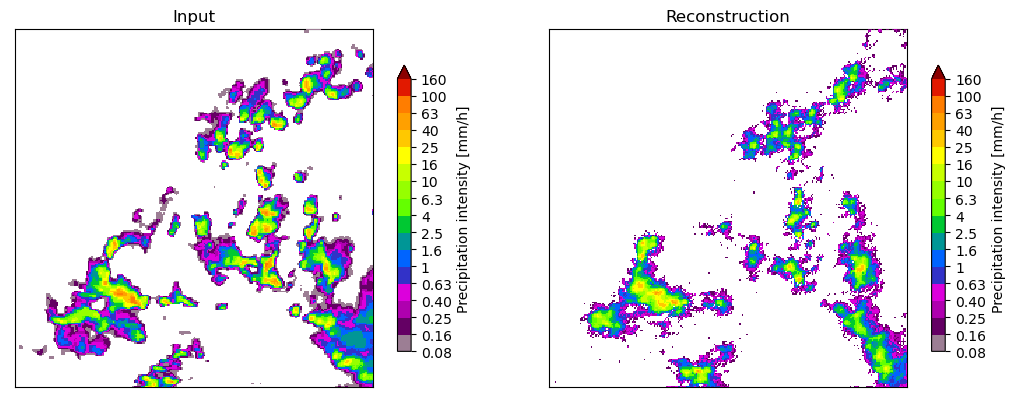

MSE: 3.327 MAE: 0.491 PCC: 0.6 
 CSI(1mm): 0.494 CSI(2mm): 0.478 CSI(8mm): 0.206 
 ACC(1mm): 0.901 ACC(2mm): 0.942 ACC(8mm): 0.984 
 FSS(1km): 0.92 FSS(10km): 0.901 FSS(20km): 0.867 FSS(30km): 0.775


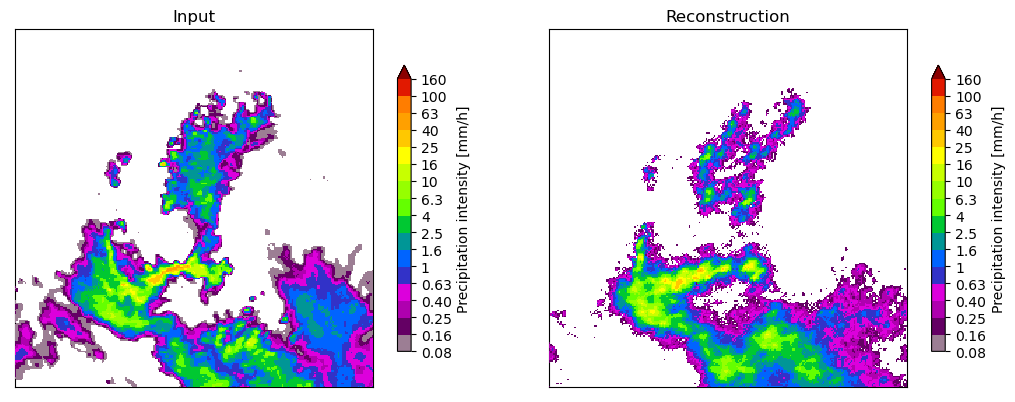

MSE: 14.817 MAE: 0.807 PCC: 0.383 
 CSI(1mm): 0.351 CSI(2mm): 0.288 CSI(8mm): 0.121 
 ACC(1mm): 0.92 ACC(2mm): 0.938 ACC(8mm): 0.97 
 FSS(1km): 0.918 FSS(10km): 0.883 FSS(20km): 0.807 FSS(30km): 0.614


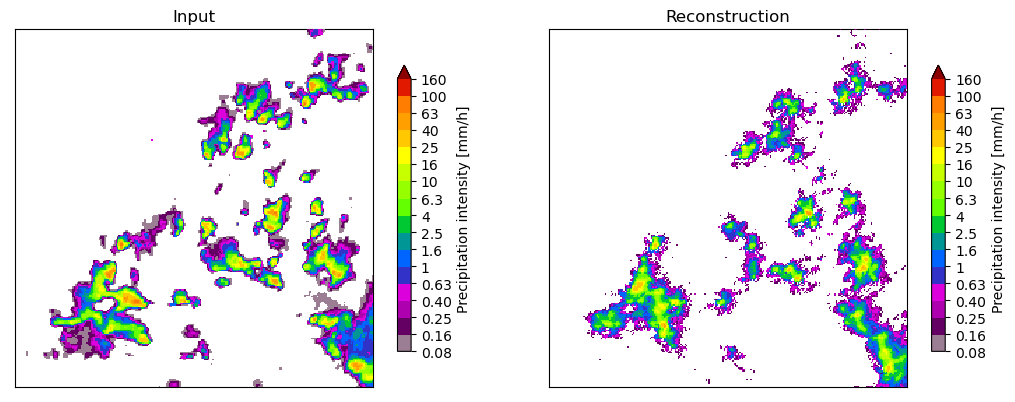

MSE: 14.848 MAE: 0.785 PCC: 0.31 
 CSI(1mm): 0.29 CSI(2mm): 0.244 CSI(8mm): 0.121 
 ACC(1mm): 0.914 ACC(2mm): 0.937 ACC(8mm): 0.971 
 FSS(1km): 0.925 FSS(10km): 0.891 FSS(20km): 0.813 FSS(30km): 0.613


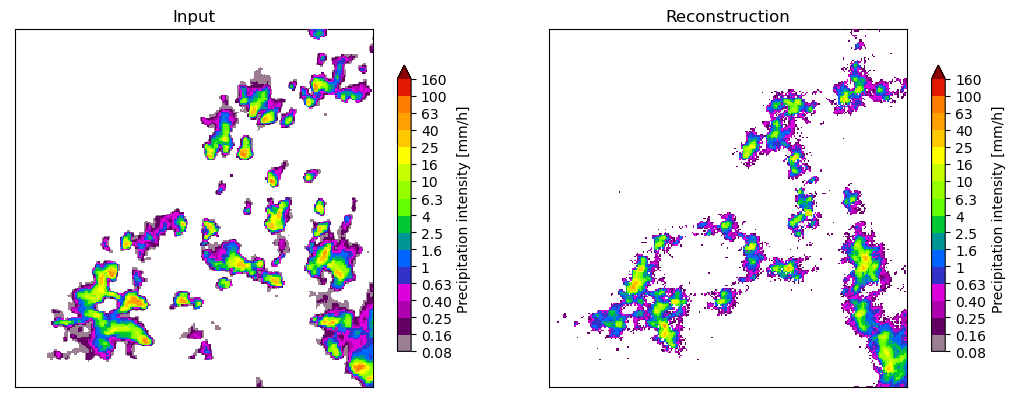

pcc_average: 0.4356


In [118]:
#torch.cuda.empty_cache()
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
threshold = 0.16
device = 'cuda:0'
pcc_average = 0
tokenizer=tokenizer.to(device)
for i, images in enumerate(loaders['test']):
    if i<0:continue
    if i>=5:break

    
    checkpoint = torch.load('/space/ankushroy/Tokeniser_exp2_1024_embdim_10/vqvae_checkpoint_epoch350', map_location=device)
    tokenizer.load_state_dict(checkpoint['model_state_dict'])
    
    image = images[0]
    image = image.unsqueeze(1)
    image = image[3:4,:, :, :]
    input_image= image.to(device)  # batch x
        #print(input_image.size())
    a_r = tokenizer.encode_decode(input_image)
        #checkpoint = torch.load('/users/zboucher/iris/src/models/tokenizer/vqvae_epoch70', map_location = 'cpu')
        #vae.load_state_dict(checkpoint)
        #a_r2 = vae(a)

    for t in range(1):
        a_display = a_r[t,0,:,:].to('cpu').detach().numpy()*40
        a_r_display = input_image[t,0,:,:].to('cpu').detach().numpy()*40
        
        a_display[a_display < threshold] = 0.0
        
        scores_cat1 = det_cat_fct(a_r_display, a_display, 1)
        scores_cat2 = det_cat_fct(a_r_display, a_display, 2)
        scores_cat8 = det_cat_fct(a_r_display, a_display, 8)
        scores_cont = det_cont_fct(a_r_display, a_display, thr=0.1)
        
        scores_spatial = intensity_scale(a_r_display, a_display, 'FSS', 0.1, [1,10,20,30])
        pcc_average += float(np.around(scores_cont['corr_p'],3))
        if True:
            print(  'MSE:', np.around(scores_cont['MSE'],3), 
                    'MAE:', np.around(scores_cont['MAE'],3), 
                    'PCC:', np.around(scores_cont['corr_p'],3),'\n', 
                    'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
                    'CSI(2mm):', np.around(scores_cat2['CSI'],3),
                    'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
                    'ACC(1mm):', np.around(scores_cat1['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                    'ACC(2mm):', np.around(scores_cat2['ACC'],3),
                    'ACC(8mm):', np.around(scores_cat8['ACC'],3),'\n',
                    'FSS(1km):', np.around(scores_spatial[0][0],3),
                    'FSS(10km):', np.around(scores_spatial[1][0],3),
                    'FSS(20km):', np.around(scores_spatial[2][0],3),
                    'FSS(30km):', np.around(scores_spatial[3][0],3)
                    )  
            plt.figure(figsize=(16, 4))
            plt.subplot(131)
            plot_precip_field(a_r_display, title="Input")
            plt.subplot(132)
            plot_precip_field(a_display, title="Reconstruction")
            
            plt.tight_layout()
            plt.show()
print('pcc_average:', pcc_average/i)

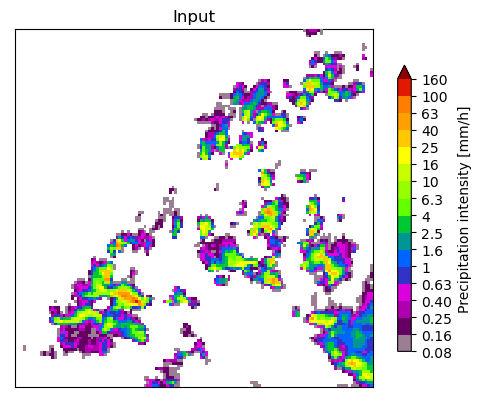

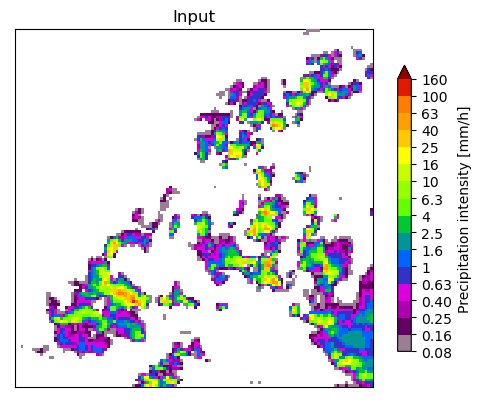

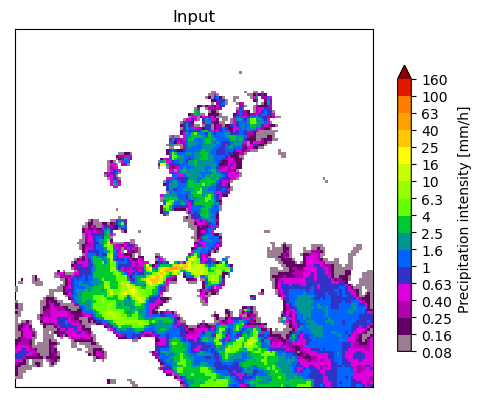

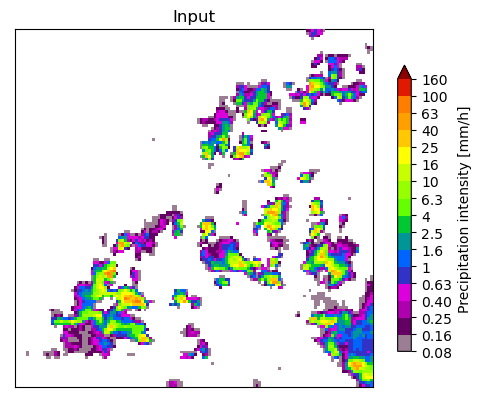

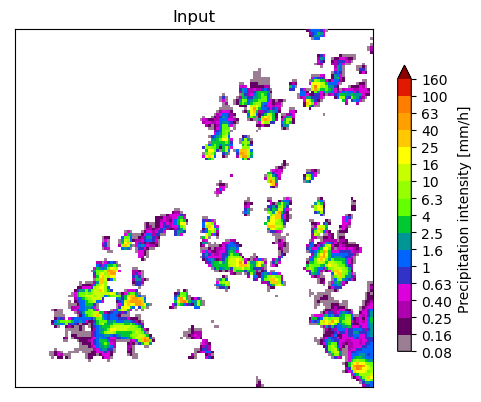

In [19]:
from pysteps.visualization import plot_precip_field
device = 'cuda:0'
for i, images in enumerate(loaders['test']):
    if i<0:continue
    if i>=5:break
    image = images[0]
    image = image.unsqueeze(1)
    image = image[3:4,:, :, :]
    input_image= image.to(device)
    
    for t in range(1):
        a_r_display = input_image[t,0,:,:].to('cpu').detach().numpy()*40
        plt.figure(figsize=(16, 4))
        plt.subplot(131)
        plot_precip_field(a_r_display, title="Input")
        plt.tight_layout()
        plt.show()

Reconstruction for 8x8 with 256 as the codebook vector dimension

MSE: 17.102 MAE: 0.892 PCC: 0.245 
 CSI(1mm): 0.292 CSI(2mm): 0.207 CSI(8mm): 0.022 
 ACC(1mm): 0.883 ACC(2mm): 0.921 ACC(8mm): 0.971 
 FSS(1km): 0.87 FSS(10km): 0.836 FSS(20km): 0.766 FSS(30km): 0.608


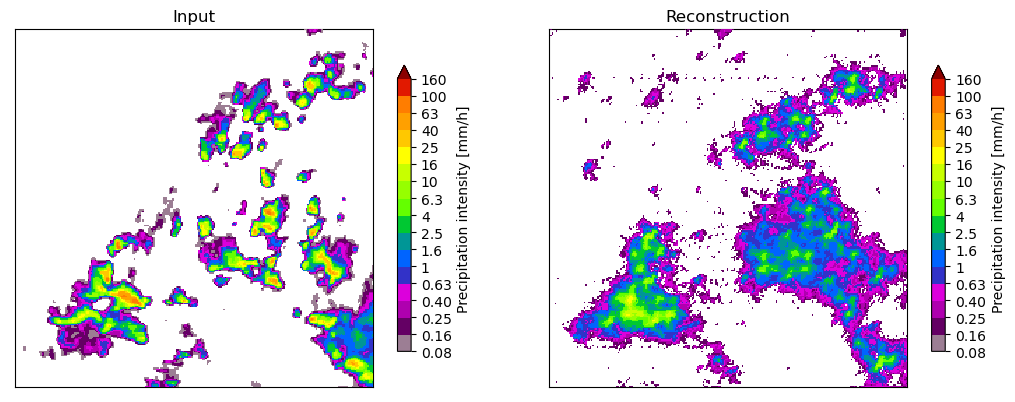

MSE: 16.413 MAE: 0.936 PCC: 0.249 
 CSI(1mm): 0.298 CSI(2mm): 0.204 CSI(8mm): 0.025 
 ACC(1mm): 0.872 ACC(2mm): 0.911 ACC(8mm): 0.969 
 FSS(1km): 0.896 FSS(10km): 0.864 FSS(20km): 0.795 FSS(30km): 0.646


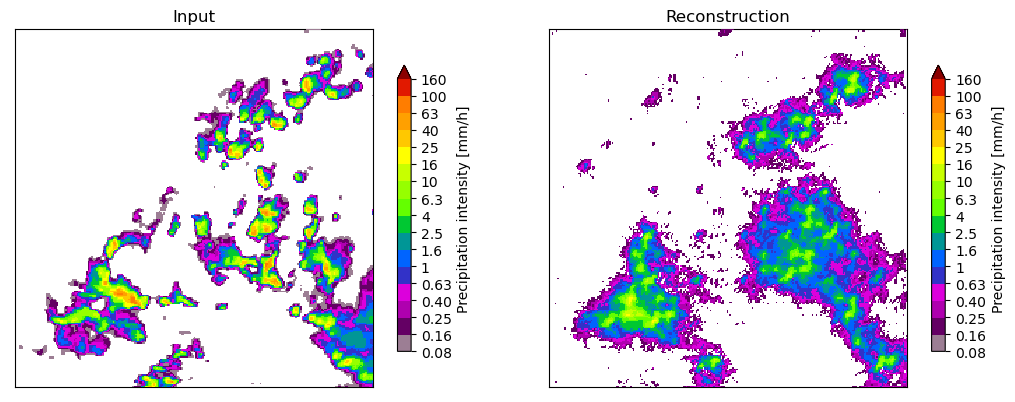

MSE: 2.914 MAE: 0.498 PCC: 0.611 
 CSI(1mm): 0.442 CSI(2mm): 0.366 CSI(8mm): 0.156 
 ACC(1mm): 0.887 ACC(2mm): 0.927 ACC(8mm): 0.989 
 FSS(1km): 0.905 FSS(10km): 0.885 FSS(20km): 0.848 FSS(30km): 0.759


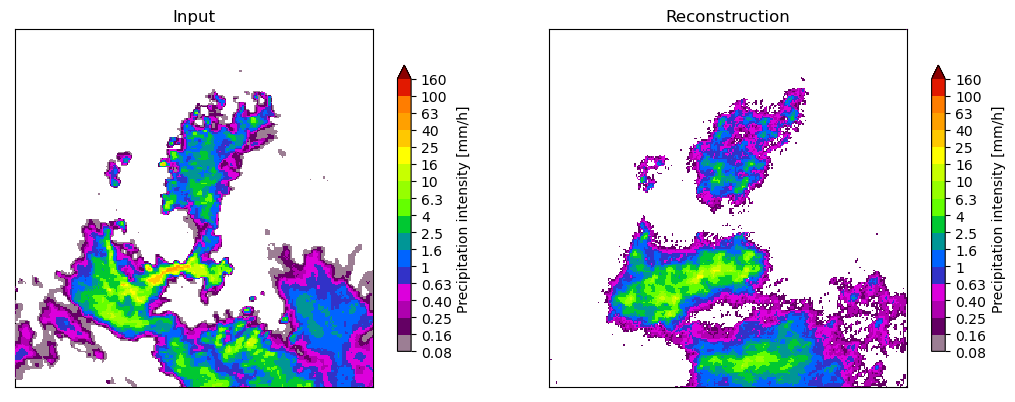

MSE: 16.313 MAE: 0.861 PCC: 0.222 
 CSI(1mm): 0.291 CSI(2mm): 0.197 CSI(8mm): 0.038 
 ACC(1mm): 0.897 ACC(2mm): 0.928 ACC(8mm): 0.971 
 FSS(1km): 0.884 FSS(10km): 0.848 FSS(20km): 0.771 FSS(30km): 0.611


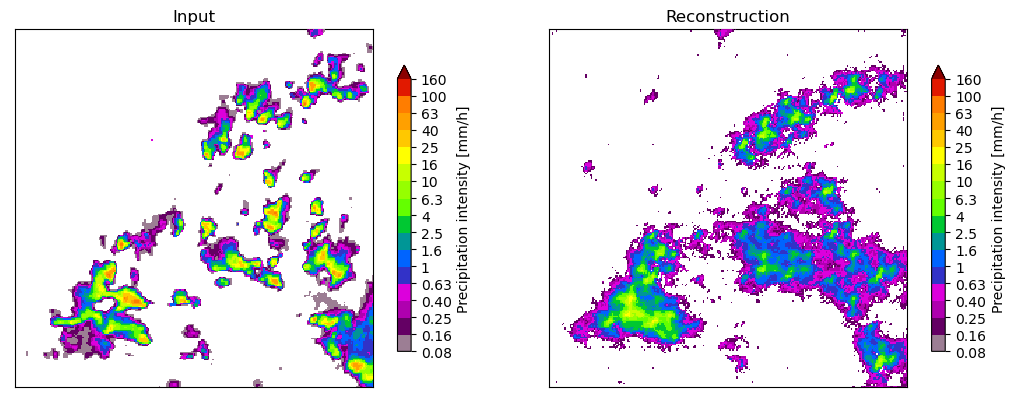

MSE: 14.754 MAE: 0.794 PCC: 0.265 
 CSI(1mm): 0.308 CSI(2mm): 0.233 CSI(8mm): 0.04 
 ACC(1mm): 0.905 ACC(2mm): 0.934 ACC(8mm): 0.972 
 FSS(1km): 0.881 FSS(10km): 0.842 FSS(20km): 0.762 FSS(30km): 0.601


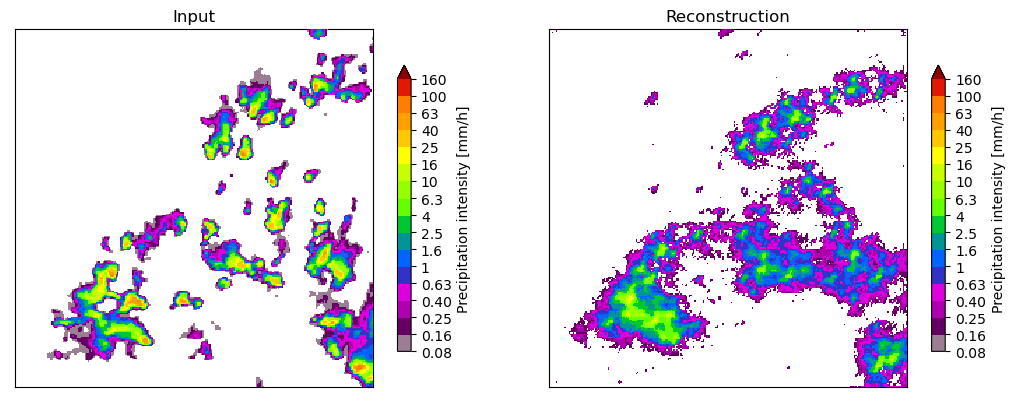

pcc_average: 0.3184


In [137]:
#torch.cuda.empty_cache()
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
threshold = 0.16
device = 'cuda:0'
pcc_average = 0
tokenizer=tokenizer.to(device)
for i, images in enumerate(loaders['test']):
    if i<0:continue
    if i>=5:break

    
    checkpoint = torch.load('/space/ankushroy/Tokeniser_exp2_1024_embdim_13/vqvae_checkpoint_epoch150', map_location=device)
    tokenizer.load_state_dict(checkpoint['model_state_dict'])
    
    image = images[0]
    image = image.unsqueeze(1)
    image = image[3:4,:, :, :]
    input_image= image.to(device)  # batch x
        #print(input_image.size())
    a_r = tokenizer.encode_decode(input_image)
        #checkpoint = torch.load('/users/zboucher/iris/src/models/tokenizer/vqvae_epoch70', map_location = 'cpu')
        #vae.load_state_dict(checkpoint)
        #a_r2 = vae(a)

    for t in range(1):
        a_display = a_r[t,0,:,:].to('cpu').detach().numpy()*40
        a_r_display = input_image[t,0,:,:].to('cpu').detach().numpy()*40
        
        a_display[a_display < threshold] = 0.0
        
        scores_cat1 = det_cat_fct(a_r_display, a_display, 1)
        scores_cat2 = det_cat_fct(a_r_display, a_display, 2)
        scores_cat8 = det_cat_fct(a_r_display, a_display, 8)
        scores_cont = det_cont_fct(a_r_display, a_display, thr=0.1)
        
        scores_spatial = intensity_scale(a_r_display, a_display, 'FSS', 0.1, [1,10,20,30])
        pcc_average += float(np.around(scores_cont['corr_p'],3))
        if True:
            print(  'MSE:', np.around(scores_cont['MSE'],3), 
                    'MAE:', np.around(scores_cont['MAE'],3), 
                    'PCC:', np.around(scores_cont['corr_p'],3),'\n', 
                    'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
                    'CSI(2mm):', np.around(scores_cat2['CSI'],3),
                    'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
                    'ACC(1mm):', np.around(scores_cat1['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                    'ACC(2mm):', np.around(scores_cat2['ACC'],3),
                    'ACC(8mm):', np.around(scores_cat8['ACC'],3),'\n',
                    'FSS(1km):', np.around(scores_spatial[0][0],3),
                    'FSS(10km):', np.around(scores_spatial[1][0],3),
                    'FSS(20km):', np.around(scores_spatial[2][0],3),
                    'FSS(30km):', np.around(scores_spatial[3][0],3)
                    )  
            plt.figure(figsize=(16, 4))
            plt.subplot(131)
            plot_precip_field(a_r_display, title="Input")
            plt.subplot(132)
            plot_precip_field(a_display, title="Reconstruction")
            
            plt.tight_layout()
            plt.show()
print('pcc_average:', pcc_average/i)

In [10]:
print(input_image.shape)
print(images.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 9, 256, 256])


In [100]:
from torchsummary import summary
input_image_tuple = (1,256,256)
summary(encoder,input_image_tuple)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 256, 256]           1,280
         GroupNorm-2        [-1, 128, 256, 256]             256
            Conv2d-3        [-1, 128, 256, 256]         147,584
         GroupNorm-4        [-1, 128, 256, 256]             256
           Dropout-5        [-1, 128, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]         147,584
       ResnetBlock-7        [-1, 128, 256, 256]               0
         GroupNorm-8        [-1, 128, 256, 256]             256
            Conv2d-9        [-1, 128, 256, 256]         147,584
        GroupNorm-10        [-1, 128, 256, 256]             256
          Dropout-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,584
      ResnetBlock-13        [-1, 128, 256, 256]               0
           Conv2d-14        [-1, 128, 1

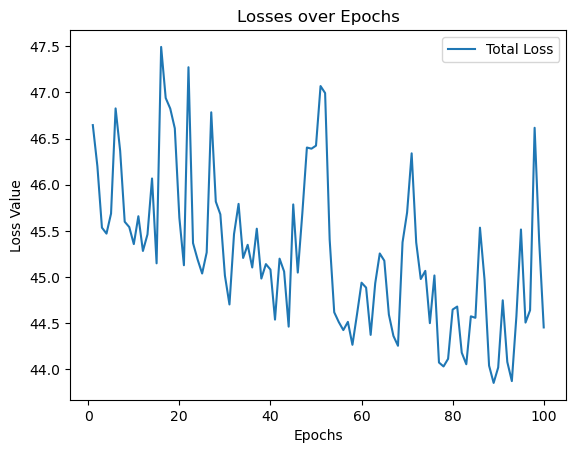

In [101]:
import numpy as np

# Load the NumPy array from file
array = np.load('/space/ankushroy/Tokeniser_exp2_1024_embdim_10/metrices.npy', allow_pickle=True)

import matplotlib.pyplot as plt

metrics = array  # List of 79 metrics dictionaries

# Create lists to store the loss values
total_losses = []
commitment_losses = []
reconstruction_losses = []
perceptual_losses = []

# Extract the loss values from each metrics dictionary
for metric in metrics:
    total_losses.append(metric["<class '__main__.Tokenizer'>/train/total_loss"])
    commitment_losses.append(metric["tokenizer/train/commitment_loss"])
    reconstruction_losses.append(metric["tokenizer/train/reconstruction_loss"])
    perceptual_losses.append(metric["tokenizer/train/perceptual_loss"])

# Plot the losses
epochs = range(1, len(metrics) + 1)

plt.plot(epochs, total_losses, label='Total Loss')
#plt.plot(epochs, commitment_losses, label='Commitment Loss')
#plt.plot(epochs, reconstruction_losses, label='Reconstruction Loss')
#plt.plot(epochs, perceptual_losses, label='Perceptual Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Losses over Epochs')
plt.legend()
plt.show()


In [102]:
print(total_losses)
#print(len(total_losses))
#print(total_losses[40:50])
#print(reconstruction_losses[40:50])

[46.645927316441885, 46.20126683747367, 45.53539977258606, 45.47075916986614, 45.68773561436501, 46.82666326155595, 46.367495122001856, 45.59934307080039, 45.54157580336505, 45.35722816107773, 45.65890429589126, 45.28281513898219, 45.462174961941855, 46.067807420213285, 45.14903172284539, 47.492433520375926, 46.93944662004469, 46.82439043838713, 46.610796201721314, 45.64254298270134, 45.128187867484485, 47.2725046211599, 45.36810627529849, 45.19133617217449, 45.03876673953164, 45.266998259663524, 46.7843547358334, 45.81730339856949, 45.67944634009291, 45.01687226796457, 44.703584273822344, 45.46485876753104, 45.79283510545065, 45.207127301535365, 45.34953192605826, 45.1042014485638, 45.52409856618942, 44.98406856850306, 45.14053920502556, 45.08099029990262, 44.53956051251316, 45.19970261840717, 45.06039729274562, 44.46334125361864, 45.786856829943645, 45.0488828522557, 45.69117639562501, 46.402931817039644, 46.39044788103456, 46.4231452207423, 47.06854037269113, 46.9929226143322, 45.40

In [9]:
import numpy as np
from collections import defaultdict
device = torch.device("cuda:0")  # Specify the GPU device
tokenizer.to(device)
checkpoint_path = '/space/ankushroy/Tokeniser_exp2_1024_embdim_13/vqvae_checkpoint_epoch210'
checkpoint = torch.load(checkpoint_path,map_location=device)
tokenizer.load_state_dict(checkpoint['model_state_dict'])
optimizer_tokenizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_total_step=0.0
intermediate_losses = defaultdict(float)

tokenizer.train()
epoch_start=210
num_epochs=220

all_metrics = []  # List to store metrics for all epochs

for epoch in range(epoch_start,num_epochs):
    save_epoch = epoch in [214,219]
    
    loss_total_epoch=0.0
    optimizer_tokenizer.zero_grad()
    intermediate_losses = {}
    print("epoch {}".format(epoch))
    for i, images in enumerate(loaders['train']):
        loss_total_step=0.0
        image = images[0]
        image = image.unsqueeze(1)
        image = image[3:4, :, :, :]
        input_image= image.to(device)  # batch x
        #print(input_image.size())
        encoder_output = tokenizer.encode(input_image)
        losses=tokenizer.compute_loss(input_image)
        
        loss_total_step += losses.loss_total 
        loss_total_epoch += loss_total_step.item()/64
        if (i+1) % 64 == 0:
            (loss_total_step/64).backward()
            optimizer_tokenizer.step()
            optimizer_tokenizer.zero_grad()
            
            print("Losses: Total = {:.4f}".format(loss_total_step.item()))
            #loss_total_step=0.0
        

        for loss_name, loss_value in losses.intermediate_losses.items():
                intermediate_losses[f"{str(tokenizer)}/train/{loss_name}"] = loss_value/64
    
        
    metrics = {f'{str(Tokenizer)}/train/total_loss': loss_total_epoch, **intermediate_losses}
    print("Epoch {}: Total Loss = {:.4f}".format(epoch, metrics[f'{str(Tokenizer)}/train/total_loss']))

    if save_epoch:
        torch.save({
        'model_state_dict': tokenizer.state_dict(),
        'optimizer_state_dict': optimizer_tokenizer.state_dict(),
        }, '/space/ankushroy/Tokeniser_exp2_1024_embdim_13/vqvae_checkpoint_epoch{}'.format(epoch+1))

    all_metrics.append(metrics)  # Save metrics for the current epoch to the list


# Convert the metrics list to a NumPy array
metrics_array = np.array(all_metrics)

# Save the metrics array as a NumPy file
np.save('/space/ankushroy/Tokeniser_exp2_1024_embdim_13/metrices_1.npy', metrics_array)
# Print all errors from each epoch's metrics dictionary
# print(all_metrics)


epoch 210
Losses: Total = 0.0894
Losses: Total = 0.0967
Losses: Total = 0.0336
Losses: Total = 0.0206
Losses: Total = 0.0710
Losses: Total = 0.0468
Losses: Total = 0.0812
Losses: Total = 0.1146
Losses: Total = 0.0443
Losses: Total = 0.0118
Losses: Total = 0.1614
Losses: Total = 0.1074
Losses: Total = 0.0965
Losses: Total = 0.0365
Losses: Total = 0.0960
Losses: Total = 0.0276
Losses: Total = 0.0374
Losses: Total = 0.1568
Losses: Total = 0.1148
Losses: Total = 0.0449
Losses: Total = 0.0934
Losses: Total = 0.0142
Losses: Total = 0.1540
Losses: Total = 0.1141
Losses: Total = 0.1438
Losses: Total = 0.0327
Losses: Total = 0.0615
Losses: Total = 0.0644


KeyboardInterrupt: 